In [115]:
# data processing libs
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np

# data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [116]:
# Seeding
seed = 0
keras.utils.set_random_seed(seed)

## Data loading and preprocessing

In [117]:
!ls -l nuts/train_n5 -L 1

ls: cannot access '1': No such file or directory
nuts/train_n5:
total 16
drwx------ 2 walltime walltime 4096 Nov 12 20:31  almonds/
drwx------ 2 walltime walltime 4096 Nov 12 20:31 'brazil nuts'/
drwx------ 2 walltime walltime 4096 Nov 12 20:31  coconut/
drwx------ 2 walltime walltime 4096 Nov 12 20:31 'pine nuts'/


In [118]:
import os

categories = ["almonds", "brazil nuts", 'coconut', 'pine nuts']

num_skipped = 0
for folder_name in (categories):
    folder_path = os.path.join("nuts/train_n5", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [119]:
### Create dataset
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "nuts/train_n5",
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)


Found 439 files belonging to 4 classes.
Using 352 files for training.
Using 87 files for validation.


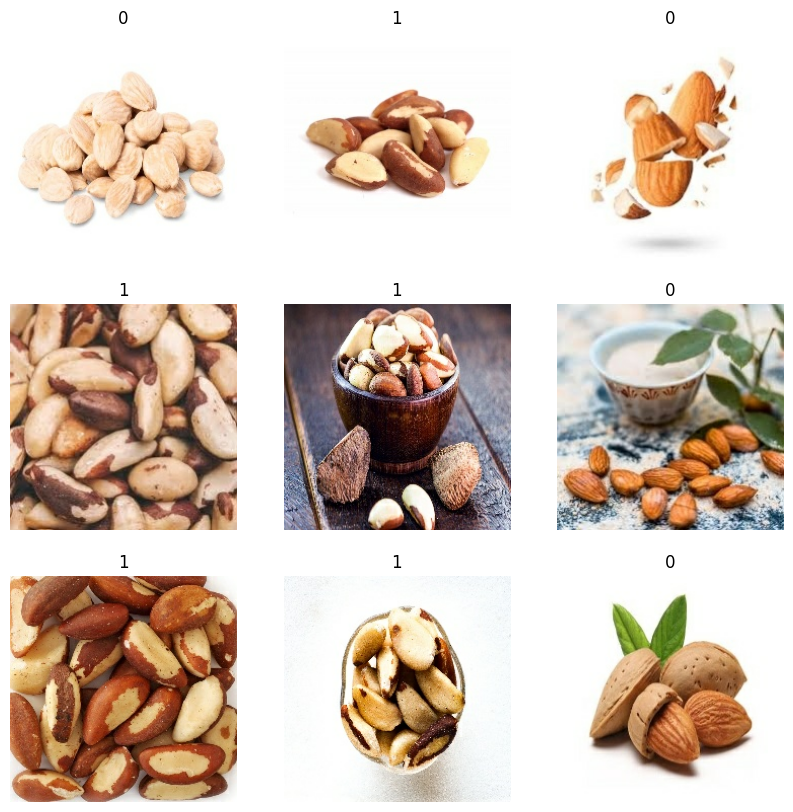

In [120]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [121]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
    ]
)

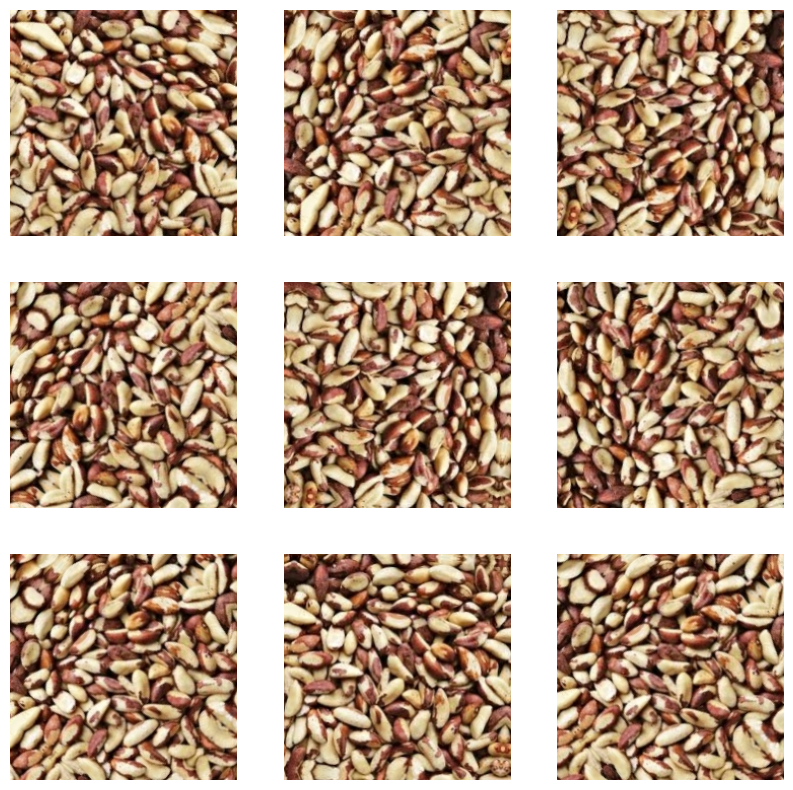

In [122]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [123]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [124]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [125]:
#   Get the imageNet and freeze
#   Final: average pooling instead of dense final layer

def make_my_model(input_shape, num_classes):

    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs) 
    x = preprocess_input(x)

    # MobileNet
    base_model=tf.keras.applications.MobileNetV2(input_shape = input_shape, weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
    base_model.trainable = False
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

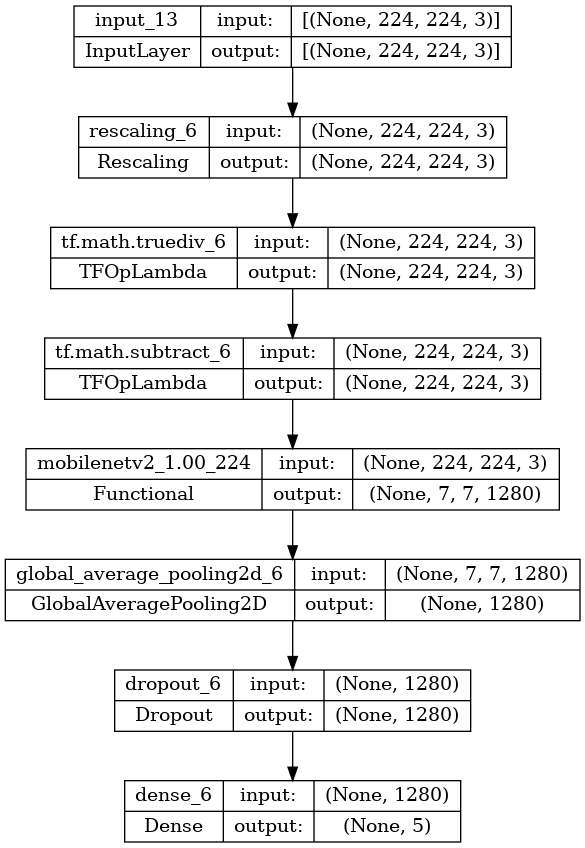

In [126]:
model = make_my_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

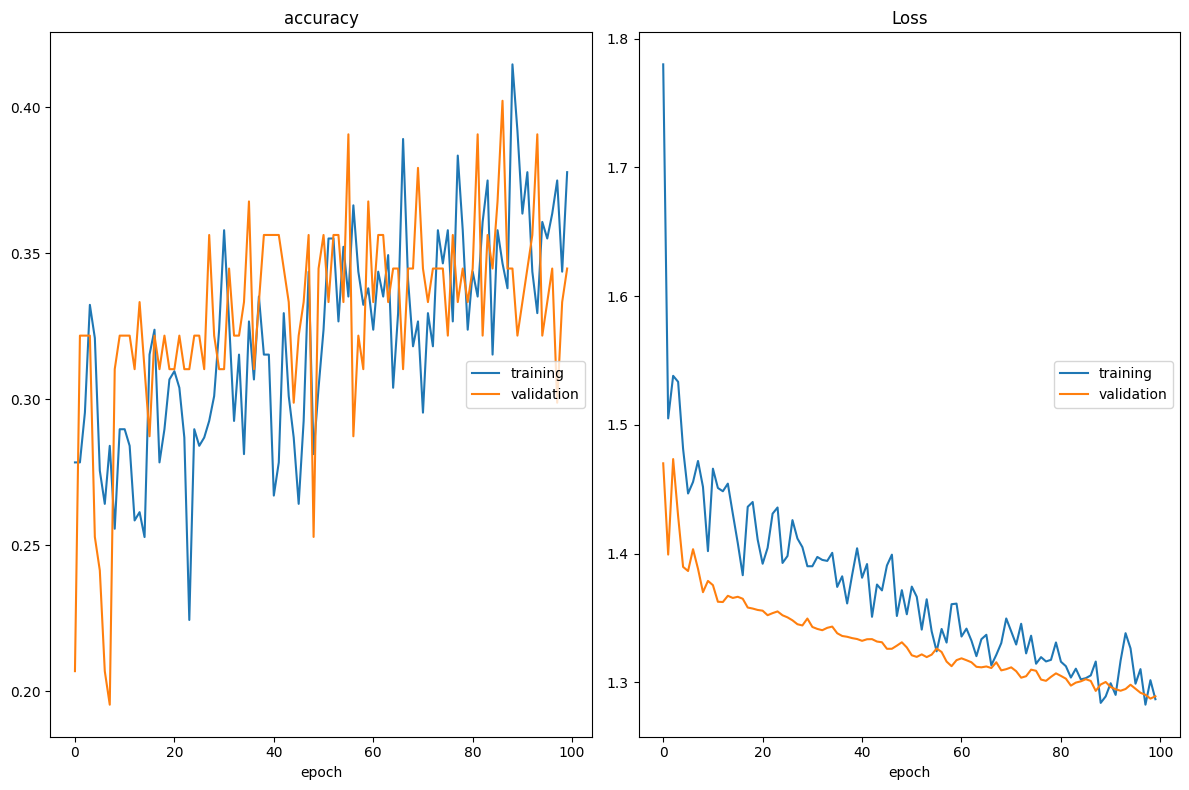

accuracy
	training         	 (min:    0.224, max:    0.415, cur:    0.378)
	validation       	 (min:    0.195, max:    0.402, cur:    0.345)
Loss
	training         	 (min:    1.283, max:    1.780, cur:    1.287)
	validation       	 (min:    1.287, max:    1.473, cur:    1.289)


In [127]:
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

epochs = 100
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 10)

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    PlotLossesKeras(), 
    monitor_val_acc
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose = 0
)

1/1 [==============================] - 0s 21ms/step
0.999999965324605
almonds 26.73 %
brazil nuts 23.97 %
coconut 31.95 %
pine nuts 17.35 %


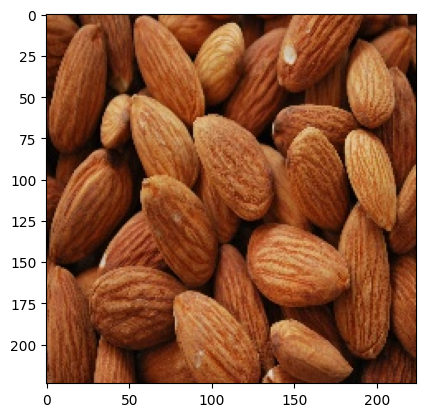

In [140]:
img = keras.utils.load_img(
    "nuts/test/almonds/5.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(sum(predictions[0]))
for i in zip(categories,predictions[0]):
    print(i[0],round(i[1]*100,2),"%")

1/1 [==============================] - 0s 23ms/step


1.000000030343017
almonds 21.84 %
brazil nuts 22.13 %
coconut 23.46 %
pine nuts 32.58 %


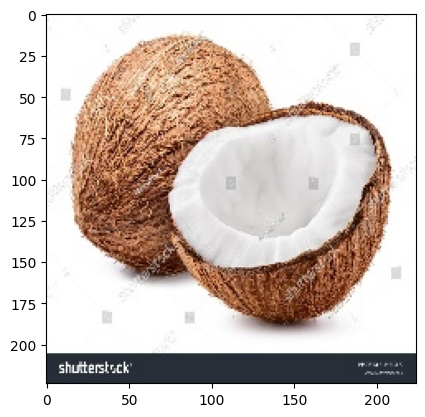

In [141]:
img = keras.utils.load_img(
    "nuts/test/coconut/1.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(sum(predictions[0]))
for i in zip(categories,predictions[0]):
    print(i[0],round(i[1]*100,2),"%")

1/1 [==============================] - 0s 19ms/step
0.9999999902033778
almonds 25.27 %
brazil nuts 33.14 %
coconut 18.56 %
pine nuts 23.03 %


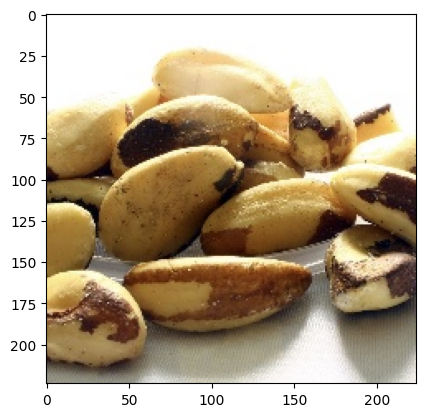

In [142]:
img = keras.utils.load_img(
    "nuts/test/brazil nuts/1.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(sum(predictions[0]))
for i in zip(categories,predictions[0]):
    print(i[0],round(i[1]*100,2),"%")

1/1 [==============================] - 0s 22ms/step


1.000000063412699
almonds 22.38 %
brazil nuts 28.26 %
coconut 17.19 %
pine nuts 32.17 %


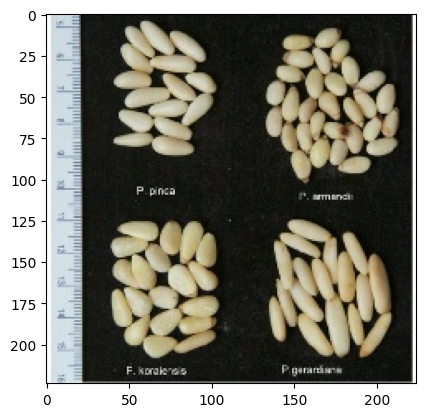

In [135]:
img = keras.utils.load_img(
    "nuts/test/pine nuts/2.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(sum(predictions[0]))
for i in zip(categories,predictions[0]):
    print(i[0],round(i[1]*100,2),"%")